# Machine Learning Project 2

In [1]:
# Imports
import pandas as pd
import numpy as np

In [2]:
# Base parameters

### Loading
# Data 
data_path = '../data/'


embeddings_file = 'embeddings_full_10epoch_100dim.npy'
embeddings_files = ['embeddings_full_10epoch_250dim_part1.npy', 
                    'embeddings_full_10epoch_250dim_part2.npy', 
                    'embeddings_full_10epoch_250dim_part3.npy']
divided_embeddings = False
embeddings_dim_info = 100
vocab_file = 'vocab_cut.txt'

# Training
local_t_size = 100_000
precomputed_file_location = '../precomputed_data/'
word_vectors_files = ['word_vectors_100000_100_part1.npy',
                     'word_vectors_100000_100_part2.npy']
divided_word_vectors = True

---
## Data Loading

In this section we load the data for :
* positive tweets, label= `:)` ($1$ for classification) 
* negative tweets, label= `:(` ($-1$ for classification)

Full data is used below (1'250'000 tweets).

In [3]:
def load_data(data_path, pos_file, neg_file, size=1_250_000): 

    # positive
    pos = pd.read_table(data_path+pos_file, sep='.\n', names=['tweet'], engine='python')
    pos['label']=1
    print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==size}")

    # negative
    neg = pd.read_table(data_path+neg_file, sep='.\n', names=['tweet'], engine='python')
    neg['label']=-1
    print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==size}")

    # Data sizes
    print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

    # Merge datasets to get a complete training set
    tweets = pos.append(neg)
    return tweets

In [4]:
# Load data
tweets = load_data(data_path, 'train_pos_full.txt', 'train_neg_full.txt')

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000



In [5]:
from glove_helper import concatenate

def load_embeddings_and_vocab(embeddings_loc, embeddings_path, vocab_loc, divided=False) :
    
    ## Load word embeddings and vocabulary to compute word vectors of tweets -----------------------------------
    
    # Load word embeddings
    embeddings=None
    if divided : 
        embeddings = concatenate(embeddings_files, embeddings_path)
    else :
        embeddings = np.load(embeddings_path+embeddings_loc)
    print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

    # Loading vocab
    words = pd.read_table(vocab_loc, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
    print(f'Loaded word vocabulary in structure of type {type(words)}.')

    # Check that the vocabulary encompasses all embedded words
    print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Clean the data --------------------------------------------------------------------------------------------

    # Drop NaN values in vocab
    nas = words.isna()
    words.dropna(inplace=True)
    # Drop NaN words in embeddings
    embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
    
    print(f'NaN values were dropped in both tables: {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Process data ---------------------------------------------------------------------------------------------
    
    # Index by words for faster index-for-word search
    words = pd.DataFrame(data=words.index, index=words.values)
    embeddings = pd.DataFrame(embeddings, index=words.index)
    
    return embeddings, words

In [6]:
embeddings, vocab = load_embeddings_and_vocab(embeddings_file, precomputed_file_location, '../data/vocab_cut.txt')

Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word vocabulary in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 100), vocab: (101298,)
NaN values were dropped in both tables: True
Embeddings: (101296, 100), vocab: (101296,)


In [8]:
vocab.head()

,0
<user>,0
!,1
i,2
the,3
.,4


---
## Exploratory Data Analysis
In this part we analyse our data in order to optimize its information.

### Cleaning tags 
Here we explore the non-spoken tags present in the tweets and determine if they are relevant for our sentiment analysis.

In [14]:
import re
from collections import defaultdict

## We check if the tags are relevant information between both pos and neg cases

def count_HTML_tags(series) :
    """
    Returns stats about the HTML tags in the tweet series.
    Returns :
    dic (defaultdict) : dict of all tags occurences.
    count (int) : count of all tags."""
    
    # Create counter for tags
    dic = defaultdict(lambda:0)
    # Create counting function
    def a(k):
        dic[k]+=1
        return None
    # Counts all encountered tags per tag
    series.apply(lambda s : [a(k) for k in re.findall('<\/*[a-zA-Z]+>', s)])
    # Counts all tags in series
    count = series.str.count('<\/*[a-zA-Z]+>').sum()
    return dic, count

def count_words(series) :
    """
    Counts the total number of words in a series of tweets.
    """
    return series.str.split().apply(len).sum()

# separate pos and neg datasets
pos, neg = tweets.loc[tweets['label']==1], tweets.loc[tweets['label']==-1]

# We query stats about the tags
d_pos, n_pos = count_HTML_tags(pos['tweet'])
d_neg, n_neg = count_HTML_tags(neg['tweet'])
all_keys = set(d_pos.keys()) | set(d_neg.keys())

print(f"|{'KEY':14s}|{'POS':6s}|{'NEG':6s}|")
for k in all_keys : 
    print(f"|{k:14s}|{d_pos[k]:6d}|{d_neg[k]:6d}|")

print(f"\nPOS tweets contain {n_pos:,} ({(n_pos-n_neg)*100/n_neg:.2f}%) HTML tags.")
print(f"NEG tweets contain {n_neg:,} ({(n_neg-n_pos)*100/n_pos:.2f}%) HTML tags.")

nw_pos, nw_neg = count_words(pos['tweet']), count_words(neg['tweet'])
nw_total = nw_pos+nw_neg

print(f"\n Frequency of tags")
print(f"Total: {(n_pos+n_neg)*100/nw_total:.3f}% ({n_pos+n_neg:,} tags for {nw_total:,} words)")
print(f"POS: {(n_pos)*100/nw_pos:.3f}% ({n_pos:,} tags for {nw_pos:,} words)")
print(f"NEG: {(n_neg)*100/nw_neg:.3f}% ({n_neg:,} tags for {nw_neg:,} words)")

|KEY           |POS   |NEG   |
|<blink>       |     0|     1|
|<summary>     |     1|     0|
|<ages>        |     0|     1|
|<emotional>   |     0|     1|
|<here>        |     1|     0|
|</script>     |     0|     4|
|<syrian>      |     0|     6|
|<thx>         |     1|     0|
|<joke>        |     1|     0|
|<user>        |1027205|578390|
|<mikel>       |     1|     0|
|<em>          |     0|     2|
|<blushing>    |     1|     0|
|<mournfully>  |     0|     1|
|<please>      |     0|     1|
|</i>          |     0|    11|
|<trans>       |     0|     3|
|<content>     |     0|     1|
|<cutestuff>   |     2|     0|
|<hot>         |     1|     0|
|<screams>     |     0|     1|
|<hahahahhahaha>|     0|     1|
|</del>        |     0|     1|
|<sciencestuff>|     2|     0|
|<sarah>       |     1|     0|
|<space>       |     3|     0|
|<dynamic>     |     1|     0|
|<weirdarms>   |     1|     0|
|<impressive>  |     1|     0|
|</popcorn>    |     1|     0|
|</moan>       |     0|     1|
|<naiv

**Note**: Although the difference in number of tags is not significant. The distribution of them is quite significant (i.e. for tags `<url>` and `<user>`). Thus we choose to leave the tags as part of the tweet. **THIS COULD BE REVIEWED TO IMPROVE PERF**

In [8]:
# Clean the HTML tags from the tweets
## CHANGE RETURN VAR IF RELEVANT

def clean_HTML_tags(series) :
    return series.str.replace('<\/*[a-zA-Z]+>', '', regex=True)

t = clean_HTML_tags(pos['tweet'])
t2 = clean_HTML_tags(neg['tweet'])

---
## Training
In this part we train the models on our data.
Thus, we perform
* a resampling of our data to work locally on a smaller set.
* the creation of word vectors for our tweets.
* a train-test-split to locally estimate the model's performance.
* cross-validation trainin on a series of models :
    * Linear Regression
    * Logistic Regression
    * SVM
    * Neural Networks

### Resampling the Training set
Using only a set of 200'000 tweets locally to decrease computation time.

In [9]:
from sklearn.utils import resample

# Take only `0.5*local_t_size` samples from both classes for faster computation
n = int(local_t_size/2)
pos_ = resample(pos, n_samples=n, replace=False)
neg_ = resample(neg, n_samples=n, replace=False)
tweets_ = pos_.append(neg_)

tweets_

,tweet,label
706939,me and my twin kind of dressed alike,1
658792,""" <user> <user> aww thanks "" welcome",1
1229186,"<user> don't worry , i'm stupid too",1
11931,"<user> hey , your amazing wish i could meet yo...",1
711440,"<user> follow back please , laura ? and can yo...",1
...,...,...
1243991,im gonna miss <user> when she leaves me,-1
967999,"<user> nothing , she left me",-1
1174022,i don't wanna go to school tomorrow,-1
2724,<user> i miss dressing up and running around n...,-1


### Word vectors creation

In [10]:
# Recall our data
print(f"Embeddings for {embeddings.shape[0]:,.1f} with {embeddings.shape[1]} features for each word.") 
print(f'Embeddings shape : {embeddings.shape}.\n')
embeddings.head(2)

Embeddings for 101,296.0 with 100 features for each word.
Embeddings shape : (101296, 100).



,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<user>,0.021177,0.007691,-0.014940,-0.026847,-0.000757,0.007441,0.018871,0.007588,0.002171,-0.022654,...,-0.011922,-0.012886,0.007829,0.000143,-0.008529,-0.036729,0.021993,0.005002,-0.015566,0.018960
!,-0.007715,0.007642,-0.005271,-0.017900,0.013720,-0.001585,-0.011057,-0.018982,-0.012275,-0.038192,...,-0.000564,-0.019415,0.003203,-0.024587,0.027616,-0.025369,0.035884,0.031967,-0.024375,-0.002844


In [72]:
def word_vector(tweet, bagofwords=False):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get vocab word embeddings
    for w in split_by_words:
        if w in words.index :
            embed_list.append(  embeddings.loc[w].values  )
        
    # Compute mean if any vocab word was found
    result = embed_list
    if bagofwords :
        if len(result) > 0 :
            max_length = np.amax([len(x) for x in result], axis=0)
            result = [np.pad(x,pad_width=(max_length-len(x)) ).tolist() for x in result]
    else :
        result = np.zeros(embeddings_dim_info) if not embed_list else np.mean(result, axis=0) 
        result = result.tolist()
    return result

In [58]:
import numpy as np
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
 
def parallelize(data, func):
    """
    Uses all CPU cores available to compute the function on each element of the data.
    """
    print(f"Computing function on {cores} cores.")
    data_split = np.array_split(data, partitions)
    print(data_split)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

import ctypes, os
# Checking if the process is executed as admin (multiprocessing does not work otherwise) 
def isAdmin():
    """
    Verifies if the process is executed as administrator.
    """
    try:
        is_admin = (os.getuid() == 0)
    except AttributeError:
        is_admin = ctypes.windll.shell32.IsUserAnAdmin() != 0
    return is_admin

In [80]:
from pandas.errors import MergeError

def get_word_vectors(tweets_, embedding_method = 'mean', recompute=False): 
    tweets_ = tweets_.copy()
    try :
        if recompute :
            raise FileNotFoundError()
        
        # Load pre-computed word vectors file if possible 
        name = precomputed_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'.npy'
        print(f"Trying to load word vectors from {name}")
        precomputed = None
        if divided_word_vectors :
            print('Loading from divided dataset...')
            precomputed = concatenate(word_vectors_files)
        else : 
            precomputed = np.load(name, allow_pickle=True)

        # Transform into Dataframe for merge
        precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
        pos_ = pos.loc[precomputed.loc[precomputed['label']==1, 'index']]
        neg_ = neg.loc[precomputed.loc[precomputed['label']==-1, 'index']]
        tweets_ = pos_.append(neg_).reset_index()
        tweets_ = tweets_.merge(precomputed, how='inner', on=['index', 'label'], validate='1:1').set_index('index')
        print('Successfully loaded from file!')

    except (FileNotFoundError, MergeError) as e :
        # Create word vectors for the local dataset
        print('Could not load word vectors from file...\nRecomputing word vectors...')
        
        func = None
        if embedding_method=='mean':
            func = word_vector
        else : 
            func = lambda t : word_vector(t, bagofwords=True) 
        
        if isAdmin():
            print('Process is run as admin. Running parallelized computation...')
            tweets_['mean_embed']= parallelize(tweets_['tweet'], func)
        else : 
            print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
            tweets_['mean_embed']= tweets_['tweet'].map(func)
            
    return tweets_

In [81]:
%time tweets_ = get_word_vectors(tweets_)

Trying to load word vectors from ../precomputed_data/word_vectors_100000_100.npy
Loading from divided dataset...
Successfully loaded from file!
Wall time: 1.04 s


In [82]:
tweets_

,tweet,label,mean_embed
index,,,
1193381,i cannot wait to party with <user> tonight,1,"[0.032002123948292126, -0.014642657203437489, ..."
644929,haha she talking shit but don't know me . gosh...,1,"[0.10238272539678156, -0.02736877932503185, 0...."
578303,"<user> excellent , as long as he keeps a bit o...",1,"[0.032941437860502285, 0.0014634508830161917, ..."
525309,<user> i'll be in mi on sunday ... i want to c...,1,"[0.04879550502681794, 0.017707842326910788, 0...."
34941,getting told you look like the person that dri...,1,"[0.1420258276670681, -0.03843481256309387, 0.0..."
...,...,...,...
1159713,<user> hey ! ! what time's your recital ? turn...,-1,"[0.15079636217861106, 0.005626630631020118, 0...."
249113,i miss being a kid . no one cared how you dres...,-1,"[0.05451928253254213, -0.052474023026710545, 0..."
913236,just cannot understand how to work tumblr prop...,-1,"[0.09112505455684311, 0.040824608634503316, 0...."


In [83]:
# Save word vectors file to gain time
def save_word_vectors(tweets_, ending=None):
    word_vectors = tweets_[['label', 'mean_embed']].reset_index()
    name = precomputed_file_location+'word_vectors_'+str(local_t_size)+'_'+str(embeddings_dim_info)
    if ending is not None :
        name = name+'_'+str(ending)
    np.save(name, word_vectors)
    return True

In [84]:
save_word_vectors(tweets_)

True

### Train-Test Split for our local dataset
We divide our local training set into a 75% training set and a 25% local testing set.

In [85]:
from sklearn.model_selection import train_test_split

def prepare_data(tweets_, test_size=0.25) : 

    # train-test split
    train_, test_ = train_test_split(tweets_, test_size=0.25)
    print(f"Local training set size : {train_.shape}.")
    print(f"Local testing set size : {test_.shape}.\n")
     
    # Create features and label datasets
    xtrain_, ytrain_ = train_.mean_embed.copy().tolist(), train_.label.copy().to_list()
    xtest_, ytest_ = test_.mean_embed.copy().tolist(), test_.label.copy().tolist()

    print('Training set first sample:\n', xtrain_[0])
    
    return xtrain_, ytrain_, xtest_, ytest_

In [86]:
xtrain_, ytrain_, xtest_, ytest_ = prepare_data(tweets_)

Local training set size : (75000, 3).
Local testing set size : (25000, 3).

Training set first sample:
 [0.08491972586172956, -0.0006829616033511412, 0.14126465341432295, -0.09241455557147843, 0.04876808797529943, -0.16686223489592514, 0.035675272561374295, -0.2940913667591907, 0.033400454715225576, -0.034256371554909355, -0.14889582795081657, -0.08566275121706629, 0.04030775117066337, -0.15073645027200966, 0.07866332548836048, 0.07052218479412098, 0.1982001088676559, -0.11791526770575726, 0.06011569947684016, 0.08166355691160566, -0.014641863636874548, -0.12742676087273666, 0.12495137724524116, 0.1588602299291537, -0.12025498151069416, -0.03804849935170046, -0.09563144564382334, -0.02009424276570287, 0.09168130082138959, -0.034246626888365383, 0.006922452892200677, 0.03741550447137739, -0.06207105838687338, 0.12388066292387201, 0.21328854159803803, -0.006238835032407843, 0.09674921125188798, 0.13512442005890177, -0.14928941057241854, 0.10771956712659773, 0.14493562273406704, 0.0331127

### Pre-Processing
Here we compute our pre-processing on features.

In [87]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess(X) :
    x=X.copy()
    
    # Standardize data
    standardizer=StandardScaler().fit_transform(x)
    
    # TODO Polynomial features and interactions
    
    # other data preprocessing
    
    return x

In [88]:
# Pre-process training set

xtrain_ = preprocess(xtrain_)
xtest_ = preprocess(xtest_)

### Estimating efficiency of model
Here we define metrics for model classification efficiency.
* Accuracy
* Precision
* Recall
* F1-Score

In [20]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

### Models Training
* Linear Regression
* Logistic Regression
* SVM
* Neural Networks

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

classifiers = dict()

In [188]:
%%time 
# Linear Regression
name = 'Linear Model'

linear_classifier = LinearRegression().fit(xtrain_, ytrain_)
score = linear_classifier.score(xtest_, ytest_)

classifiers[name] = (linear_classifier, score)

print(f"R2 score for {name} is {score}.")

R2 score for Linear Model is 0.0528607913232263.
Wall time: 2.47 s


In [189]:
%%time 
# Logistic Regression
name = 'Logistic Regression'

logistic_classifier = LogisticRegression().fit(xtrain_, ytrain_)
score = logistic_classifier.score(xtest_, ytest_)

classifiers[name] = (logistic_classifier, score)

print(f"R2 score for {name} is {score}.")

# Logistic Regression using Crossvalidation
name = 'Logistic Regression using cross-validation'

logisticCV_classifier = LogisticRegressionCV().fit(xtrain_, ytrain_)
score = logisticCV_classifier.score(xtest_, ytest_)

classifiers[name] = (logisticCV_classifier, score)

print(f"R2 score for Logistic Regression model using cross-validation is {score}.")

R2 score for Logistic Regression is 0.59272.
R2 score for Logistic Regression model using cross-validation is 0.5928.
Wall time: 16.5 s


In [190]:
# Compute predictions
predtest_ = logistic_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.57472   0.70490   0.63319     12467
         neg    0.62107   0.48113   0.54222     12533

    accuracy                        0.59272     25000
   macro avg    0.59790   0.59302   0.58770     25000
weighted avg    0.59796   0.59272   0.58758     25000



In [191]:
# Compute predictions
predtest_ = logisticCV_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.57441   0.70803   0.63426     12467
         neg    0.62213   0.47818   0.54074     12533

    accuracy                        0.59280     25000
   macro avg    0.59827   0.59310   0.58750     25000
weighted avg    0.59834   0.59280   0.58738     25000



In [192]:
%%time 
# Support Vector Machines
name = 'SVM classifier'

SVM_classifier = LinearSVC().fit(xtrain_, ytrain_)
score = SVM_classifier.score(xtest_, ytest_)

classifiers[name] = (SVM_classifier, score)

print(f"R2 score for {name} model is {score}.")

C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


R2 score for SVM classifier model is 0.59404.
Wall time: 1min 7s


In [22]:
%%time
#### BASELINE : Neural Networks

# Neural Network
name = 'Neural Network'

nn_classifier = MLPClassifier().fit(xtrain_,ytrain_)
score = nn_classifier.score(xtest_,ytest_)

classifiers[name] = (nn_classifier, score)

print(f"R2 score for {name} classifier is {score}.")

C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


R2 score for Neural Network classifier is 0.608.
Wall time: 1min 45s


In [23]:
# Compute predictions
predtest_ = nn_classifier.predict(xtest_)

metrics = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5, output_dict=True)
report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.59458   0.67380   0.63172     12474
         neg    0.62546   0.54247   0.58102     12526

    accuracy                        0.60800     25000
   macro avg    0.61002   0.60814   0.60637     25000
weighted avg    0.61005   0.60800   0.60631     25000



In [195]:
# Save baseline results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_baseline'
np.save(name, metrics)

### Custom models
Let us implement a custom model following the paper $\text{Text Classification with Deep Neural Networks}$ by *Maaz Amajd et al.* from Microsoft.

#### Recompute word vectors datasets
The convolutionnal Neural Network uses a matrix as input format. Here we use a matrix of words vectors representing the tweet.

In [74]:
tweets_cnn = get_word_vectors(tweets_, embedding_method='BOW', recompute=True)

Could not load word vectors from file...
Recomputing word vectors...
Process is not run as admin. Cannot run parallelized setting, running as sequential...


In [64]:
save_word_vectors(tweets_cnn, ending='cnn')
tweets_cnn

,tweet,label,mean_embed
index,,,
1193381,i cannot wait to party with <user> tonight,1,"[[0.006390639092777149, -0.002517977760506535,..."
644929,haha she talking shit but don't know me . gosh...,1,"[[0.095365011208915, -0.002271404137185445, 0...."
578303,"<user> excellent , as long as he keeps a bit o...",1,"[[0.021176976452678558, 0.007691384674272959, ..."
525309,<user> i'll be in mi on sunday ... i want to c...,1,"[[0.021176976452678558, 0.007691384674272959, ..."
34941,getting told you look like the person that dri...,1,"[[0.07722609727291953, -0.015988683796022186, ..."
...,...,...,...
1159713,<user> hey ! ! what time's your recital ? turn...,-1,"[[0.021176976452678558, 0.007691384674272959, ..."
249113,i miss being a kid . no one cared how you dres...,-1,"[[0.006390639092777149, -0.002517977760506535,..."
913236,just cannot understand how to work tumblr prop...,-1,"[[0.06250523629347589, -0.01246092651515487, 0..."


In [94]:
xtrain_cnn, ytrain_cnn, xtest_cnn, ytest_cnn = prepare_data(tweets_cnn)

Local training set size : (75000, 3).
Local testing set size : (25000, 3).

Training set first sample:
 [[0.03874826280722202, -0.0226154273381748, 0.06331501800493958, -0.05300686099727286, -0.02604800050298649, -0.06584109852584337, -0.008828779663752315, -0.10206945408357572, -0.00353245552938762, -0.029851338185586506, -0.0332773668685895, -0.0772952293011356, -0.028125405154649213, -0.07623803516338871, 0.02133121024922275, 0.02422468594373341, 0.01366152352805924, -0.02749200397469116, 0.09053584800823926, -0.023833276378709092, 0.004043477932097031, -0.05621087884414685, 0.0526542836005664, 0.045542285624793066, -0.033528027208590556, -0.017383583133306613, -0.03443335386155496, -0.10966482189803363, 0.04206032044073065, -0.07445478974047048, 0.007670329872138221, 0.0509657715676167, -0.014440089971403428, 0.11515830005637248, 0.10204113604695303, -0.04486226197048761, 0.0791685780560366, 0.025574548862244122, -0.045750544964075976, 0.0499636137507949, 0.03762462946514737, 0.043

In [ ]:
xtrain_cnn

In [34]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Define base parameters for the CNN

batch_size = 64 ## TODO tune batch size (depends on mem)
epochs = 20
num_classes = 2

In [54]:
xtrain_, ytrain_ = np.array(xtrain_), np.array(ytrain_)
xtest_, ytest_ = np.array(xtest_), np.array(ytest_)

(75000, 100)

In [55]:
# Create the layers of the CNN
cnn_classifier = Sequential()
cnn_classifier.add(Conv1D(32, kernel_size=2,activation='relu',input_shape=xtrain_.shape[] ,padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))
cnn_classifier.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_classifier.add(Conv1D(64, 2, activation='relu',padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))
cnn_classifier.add(MaxPooling1D(pool_size=2,padding='same'))
cnn_classifier.add(Conv1D(128, kernel_size=2, activation='relu',padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))                  
cnn_classifier.add(MaxPooling1D(pool_size=2,padding='same'))
cnn_classifier.add(Flatten())
cnn_classifier.add(Dense(128, activation='linear'))
cnn_classifier.add(LeakyReLU(alpha=0.1))                  
cnn_classifier.add(Dense(num_classes, activation='softmax'))

cnn_classifier.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_classifier.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 75000, 32)         6432      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 75000, 32)         0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 37500, 32)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 37500, 64)         4160      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 37500, 64)         0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 18750, 64)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 18750, 128)      

In [56]:
%%time
# Train the model
cnn_history = cnn_classifier.fit(xtrain_, ytrain_, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(xtest_, ytest_))

Epoch 1/20


ValueError: in user code:

    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_14 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 100]


In [ ]:
# Save CNN results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_CNN'
np.save(name, metrics)

---
## Testing
This section is dedicated to using the previous classifiers to predict the labels of the provided testing set.

In [196]:
# To format the testing data
def extract_tweet(tweet):
    return tweet.split(",", 1)[1]

In [197]:
## Loading data

# Load the testing data
test = pd.read_fwf(data_path+ 'test_data.txt', sep="\n", header=None)
test = test.rename(columns={0:'tweet', 1:'na1', 2:'na2'})

# Reformating it for submission
test.index = test.index+1 # Format asked by AI Crowd
test = test['tweet'].map(extract_tweet).to_frame()

test

,tweet
1,sea doo pro sea scooter ( sports with the port...
2,<user> shucks well i work all week so now i ca...
3,i cant stay away from bug thats my baby
4,<user> no ma'am ! ! ! lol im perfectly fine an...
5,"whenever i fall asleep watching the tv , i alw..."
...,...
9996,had a nice time w / my friend lastnite
9997,<user> no it's not ! please stop !
9998,not without my daughter ( dvd two-time oscar (...
9999,<user> have fun in class sweetcheeks


In [198]:
## Preparing data

# Create word vectors for tweets
test['mean_embed'] = test['tweet'].map(word_vector)

# Preprocess test data
xtest = preprocess(test.mean_embed.copy().tolist())

xtest[:1]

[[0.14106374638176422,
  -0.06872910829415042,
  0.10606407952823267,
  -0.09969504582330192,
  -0.09938122724092968,
  0.28317441988314734,
  0.12138428352938964,
  -0.1517520964155663,
  0.10356461464215022,
  -0.11447167273952473,
  -0.1019050178288262,
  0.04473441812472089,
  0.12753700910123314,
  -0.014779420598848767,
  0.10883114641696463,
  -0.027001854853501504,
  0.10577392355516102,
  -0.01237564492214693,
  -0.08728130073213365,
  -1.3278300604051836e-05,
  0.001988548783500319,
  0.09713995903112027,
  0.15960496406624083,
  0.03955682032454823,
  0.06123988498368808,
  0.017050798883699113,
  0.021711058586347004,
  0.02652509905392398,
  0.07778597342590884,
  0.04948356934673396,
  -0.0368192989347208,
  0.0066128325730812725,
  -0.05402086630132191,
  0.06544012906493839,
  0.00942711268585168,
  -0.14003847327412292,
  0.027678123328473192,
  -0.024907247810668574,
  0.06029466012331888,
  -0.016807239895609543,
  -0.0875419342687434,
  -0.04261577293113893,
  0.116

In [199]:
# Recalling classifiers 
# stored in format : 'classifier name'=(classifier, R2 score) 

print(f"Models computed so far are the following.\n ")
print(f"{'Classifier':50s} | {'R2 Score':20s}")
print(f"-----------------------------------------------------------------")
for k,v in classifiers.items() :
    print(f"{k:50s} | {v[1]:10.10f}")
print('\n')

Models computed so far are the following.
 
Classifier                                         | R2 Score            
-----------------------------------------------------------------
Linear Model                                       | 0.0528607913
Logistic Regression                                | 0.5927200000
Logistic Regression using cross-validation         | 0.5928000000
SVM classifier                                     | 0.5940400000
Neural Network                                     | 0.6162800000




In [200]:
# Making predictions
model = classifiers['Neural Network'][0]

predictions = model.predict(xtest)

In [201]:
# Creating submission file
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})
            
create_csv_submission(test.index, predictions, '../submission/submission.csv')

## Results
Here we detail previously computed results from `results/` folder.

### GloVe Dimensions evolution
Below we detail how different metrics perform when the dimension of the word embeddings computed by GloVe algorithm changes.

In [213]:
accs = []
precs = []
recs = []
f1s = []


for d in [20,50,100,250] :
    print(f'\n{d} dimensions\n')
    name = path+'metrics_'+str(local_t_size)+'_'+str(d)+'_baseline.npy'
    r = np.load(name, allow_pickle=True)
    r = r.item()
    print(f"Accuracy : {r['accuracy']}")
    print(f"{'Label':10s} | {'precision':10s} | {'recall':10s} | {'f1-score':10s}")
    print(f"{'pos':10s} | {r['pos']['precision']:10f} | {r['pos']['recall']:10f} | {r['pos']['f1-score']:10f}")    
    print(f"{'neg':10s} | {r['neg']['precision']:10f} | {r['neg']['recall']:10f} | {r['neg']['f1-score']:10f}")  
    accs.append(r['accuracy'])
    precs.append(r['pos']['precision'])
    recs.append(r['pos']['recall'])
    f1s.append(r['pos']['f1-score'])


20 dimensions

Accuracy : 0.585
Label      | precision  | recall     | f1-score  
pos        |   0.574874 |   0.671121 |   0.619280
neg        |   0.599399 |   0.497868 |   0.543936

50 dimensions

Accuracy : 0.5896
Label      | precision  | recall     | f1-score  
pos        |   0.575301 |   0.671701 |   0.619775
neg        |   0.609460 |   0.508167 |   0.554223

100 dimensions

Accuracy : 0.60904
Label      | precision  | recall     | f1-score  
pos        |   0.587911 |   0.726698 |   0.649979
neg        |   0.643141 |   0.491608 |   0.557257

250 dimensions

Accuracy : 0.61628
Label      | precision  | recall     | f1-score  
pos        |   0.634955 |   0.542312 |   0.584988
neg        |   0.602425 |   0.689859 |   0.643184


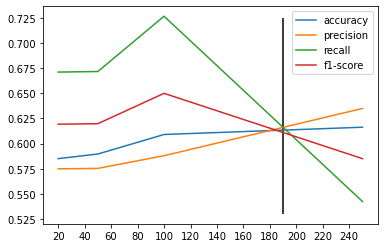

In [236]:
import matplotlib.pyplot as plt
x = [20,50,100,250]
plt.plot(x, accs)
plt.plot(x, precs)
plt.plot(x, recs)
plt.plot(x, f1s)
plt.legend(['accuracy','precision','recall','f1-score'])
plt.xticks(ticks=np.arange(0,260,20))
plt.vlines(190,ymin=0.53, ymax=0.725, color='black')
name = '../plots/'+'metrics_'+str(local_t_size)+'_dims_baseline.png'
plt.savefig(name, dpi=1000)
plt.show()


We note that the optimal number of dimensions seems to lie around **190** as the parameters are at their common highest at this point.